# Requirment

In [1]:
!pip install langchain langgraph openai beautifulsoup4 requests datasets python-dotenv flask langchain-nvidia-ai-endpoints GoogleNews


# Importing

In [ ]:
import os
from dotenv import load_dotenv
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import requests
from bs4 import BeautifulSoup
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import json
from flask import Flask, render_template_string
from langgraph.graph import StateGraph
from GoogleNews import GoogleNews
from google.colab import userdata
import base64
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from langgraph.graph import StateGraph
from langgraph.graph import StateGraph
from typing import TypedDict



# Keys

In [ ]:
# Define the API keys on colab
NVIDIA_API_KEY  = userdata.get('nividia_api_key')
stable_dev_api_key  = userdata.get('stable_dev_api_key')

# LLM calling

In [ ]:
# define llm using llama 3.1-450b

def generate_content(messages):
    url = "https://integrate.api.nvidia.com/v1/chat/completions"

    payload = {
        "model": "meta/llama-3.1-405b-instruct",
        "messages": messages,
        "temperature": 0,
        "top_p": 0.7,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "max_tokens": 1024,
        "stream": False,
        "stop": ["string"]
    }
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "authorization": NVIDIA_API_KEY
    }
    response = requests.post(url, json=payload, headers=headers)
    response = json.loads(response.text)
    return response["choices"][0]["message"]["content"]

# Message structure

In [ ]:
# Structure the message
def structure_messge(prompt,*args):
  if len(args) == 1:
     message =  prompt%args
  else :
    message =  prompt%(args[0], args[1])
  messages = [{"role": "user", "content": message}]
  return messages

# Fetch trending topics

In [ ]:
# Fetch the trending AI topics from Google News
def fetch_topics(keyword="AI NLP", num_articles=10):
    """Fetches trending AI topics from an external source """
    googlenews = GoogleNews(lang='en', region='US', period='2d')
    googlenews.search(keyword)
    results = googlenews.result()[:num_articles]
    return [article['title'] for article in results]

articles = fetch_topics()

In [119]:
len(articles)

10

# Refine Content Generation with AI

In [ ]:
# Refine the generation content
def refine_content(selected_topic,content,refine_prompt, iterations=4):
    for i in tqdm(range(iterations)):
        messages = structure_messge(refine_prompt,selected_topic,content)
        content = generate_content(messages)
    return content

# Topic SElection

In [ ]:
# Topic Selection from USER
def select_topic(topics):
    print("\nSelect a topic:")
    for idx, topic in enumerate(topics, 1):
        print(f"{idx}. {topic}")
    print("**********************************************")
    choice = int(input("Enter the number of your chosen topic: ")) - 1
    print("**********************************************")
    return topics[choice]

selected_topic = select_topic(articles)
print(f"Selected Topic: {selected_topic}")



Select a topic:
1. Revolutionizing Support: AI-Powered Customer Service
2. How AI is Becoming More Human-Like With Emotional Intelligence
3. Healthcare Virtual Assistant Market to Reach $6248 Million by 2031, Driven by AI and NLP Innovations | Valuates Reports
4. Movate Technologies in Partnership with The Ma Foi Foundation launches Advanced Generative AI Lab at Mount Carmel College, Bangalore
5. Conversational GenAI: Building Advanced Virtual Assistants
6. Redefining Clinical Trials with Artificial Intelligence
7. Discovery Series – Harnessing AI: Natural Language Processing in Healthcare and Beyond
8. How AI language tools can help us understand human behavior
9. The impact of NLP on chatbot capabilities: The fintech perspective
10. The rise of AI-powered chatbots in digital apps
**********************************************
Enter the number of your chosen topic: 0
**********************************************
Selected Topic: The rise of AI-powered chatbots in digital apps


# PROMPTS


In [ ]:
main_prompt = f"""
Write a well-structured, engaging blog post about %s in a professional yet friendly tone. Your post should:

## Structure and Format
- Begin with a compelling headline that includes relevant keywords for SEO
- Start with a strong hook in the introduction that identifies the reader's pain point or curiosity
- Include 5-7 clear sections with descriptive H2 subheadings
- Incorporate 2-3 relevant examples or case studies that illustrate key points
- End with a conclusion that summarizes the main takeaways and includes a clear call-to-action

## Content Elements
- Provide at least 3 actionable tips or strategies the reader can implement immediately
- Include 1-2 relevant statistics or research findings with their sources
- Address potential objections or counterarguments in a balanced way
- Incorporate bullet points or numbered lists to break up text and enhance readability
- Suggest 2-3 recommended resources for readers who want to learn more

## Tone and Style
- Write in a professional yet conversational tone as if speaking to a knowledgeable colleague
- Use second-person "you" perspective to directly address the reader
- Avoid jargon unless defining it clearly for the target audience
- Include thoughtful transitions between sections for smooth reading flow
- Incorporate occasional rhetorical questions to engage the reader

## Length and Detail
- Write approximately 1,200-1,500 words total
- Include a brief author bio at the end with relevant credentials to establish expertise
- Suggest 3-5 tags or categories that would be appropriate for this blog post

"""
refine_prompt = f"""
You are an expert editor refining an AI blog post related to %s.
Your goal is to improve the content while maintaining its original intent.
You will be given a previous version of the blog post, and you must refine it according to the following **four key criteria**.

### **Previous Blog Post**
%s

### **Refinement Guidelines**
Improve the blog post by focusing on:
- **Clarity**: Simplify complex sentences and ensure easy readability.
- **Coherence**: Ensure smooth transitions between sections for logical flow.
- **Engagement**: Improve storytelling, use an active voice, and add compelling phrasing.
- **Accuracy**: Verify factual correctness, particularly AI-related claims.

-  you must generate a new refined content in the following format
**Output Format**

output format :


"""
image_prompt = f"""
You are a professional AI-generated image creator. Your task is to generate a **high-quality, visually appealing, and conceptually relevant image** based on the following topic:

### **Topic: %s**

#### **Image Style & Composition:**
- The image should be an **artistic yet realistic representation** of the topic.
- Use a **modern, futuristic, and visually engaging style** that aligns with AI and technology themes.
- Ensure the composition is **balanced, clear, and professional**.

#### **Key Elements to Include:**
- **Core AI Theme:** Depict AI in a way that represents its role in the given topic (e.g., neural networks, futuristic interfaces, robotic elements).
- **Context-Specific Details:** Ensure that the image aligns with the specific focus of the topic.
- **Aesthetic Appeal:** Use a **clean, professional, and dynamic color scheme** with attention to lighting and depth.

#### **Examples for Inspiration:**
- **For AI in Workplace Productivity:** A futuristic office with AI-driven automation, smart assistants, and holographic interfaces.
- **For AI in Scientific Research:** A digital laboratory with AI analyzing complex data visualizations on large interactive screens.
- **For AI in Ethics & Regulation:** A symbolic representation of AI decision-making, with law and governance themes integrated into a tech-based setting.

### **Technical Considerations:**
- The image should be in **high resolution**.
- Ensure **sharp details, vivid colors, and balanced lighting**.
- Avoid unnecessary clutter; keep the focus on the main AI-related elements.

Generate an image that effectively represents the given topic in a **creative, engaging, and professional manner**.
"""


## Examples

In [131]:
messages = structure_messge(main_prompt,selected_topic)
blog_post = generate_content(messages)

[{'role': 'user', 'content': '\nWrite a well-structured, engaging blog post about The rise of AI-powered chatbots in digital apps in a professional yet friendly tone. Your post should:\n\n## Structure and Format\n- Begin with a compelling headline that includes relevant keywords for SEO\n- Start with a strong hook in the introduction that identifies the reader\'s pain point or curiosity\n- Include 5-7 clear sections with descriptive H2 subheadings\n- Incorporate 2-3 relevant examples or case studies that illustrate key points\n- End with a conclusion that summarizes the main takeaways and includes a clear call-to-action\n\n## Content Elements\n- Provide at least 3 actionable tips or strategies the reader can implement immediately\n- Include 1-2 relevant statistics or research findings with their sources\n- Address potential objections or counterarguments in a balanced way\n- Incorporate bullet points or numbered lists to break up text and enhance readability\n- Suggest 2-3 recommended 

In [132]:
print(blog_post)

**The Rise of AI-Powered Chatbots in Digital Apps: Revolutionizing Customer Experience**

Are you tired of feeling like you're stuck in a never-ending loop of automated phone menus and unhelpful customer support emails? You're not alone. As consumers increasingly turn to digital channels to interact with businesses, the demand for more personalized, efficient, and responsive customer experiences has never been higher. That's where AI-powered chatbots come in – and they're changing the game.

**What are AI-Powered Chatbots, Anyway?**

Before we dive into the benefits and best practices of AI-powered chatbots, let's define what we mean by this term. Simply put, AI-powered chatbots are computer programs that use artificial intelligence (AI) and natural language processing (NLP) to simulate human-like conversations with users. These chatbots can be integrated into digital apps, websites, and even messaging platforms to provide 24/7 customer support, answer frequently asked questions, and e

In [138]:
refined_blog_post = refine_content(selected_topic,blog_post,refine_prompt)

100%|██████████| 4/4 [02:18<00:00, 34.59s/it]


In [140]:
refined_blog_post

'**The Rise of AI-Powered Chatbots in Digital Apps: Revolutionizing Customer Experience**\n\nAre you tired of navigating endless automated phone menus and unhelpful customer support emails? You\'re not alone. As consumers increasingly turn to digital channels to interact with businesses, the demand for more personalized, efficient, and responsive customer experiences has never been higher. That\'s where AI-powered chatbots come in – and they\'re changing the game.\n\n**Unlocking the Power of AI-Powered Chatbots**\n\nImagine having a conversation with a computer program that understands you like a human would. AI-powered chatbots harness artificial intelligence (AI) and natural language processing (NLP) to simulate human-like conversations with users. By integrating these chatbots into digital apps, websites, and messaging platforms, businesses can provide 24/7 customer support, answer frequently asked questions, and even facilitate transactions.\n\n**The Benefits of AI-Powered Chatbots

# Image generation

In [ ]:
# Generating Images with AI
def generate_image(selected_topic):


    invoke_url = "https://ai.api.nvidia.com/v1/genai/briaai/bria-2.3"

    headers = {
        "Authorization": stable_dev_api_key,
        "Accept": "application/json",
    }

    payload = {
        "prompt": image_prompt%selected_topic,
        "cfg_scale": 5,
        "aspect_ratio": "16:9",
        "seed": 0,
        "steps": 50,
        "negative_prompt": ""
    }

    response = requests.post(invoke_url, headers=headers, json=payload)

    response.raise_for_status()
    response_body = response.json()

    # Set image_data to None
    image_data = response_body["image"]

    # Decode the base64 image data
    image_bytes = base64.b64decode(image_data)
    image = Image.open(BytesIO(image_bytes))
    # save the image in directory
    image.save("./static/generated_image.png")
    image_url = "./static/generated_image.png"
    return image_url

image_url = generate_image(selected_topic)

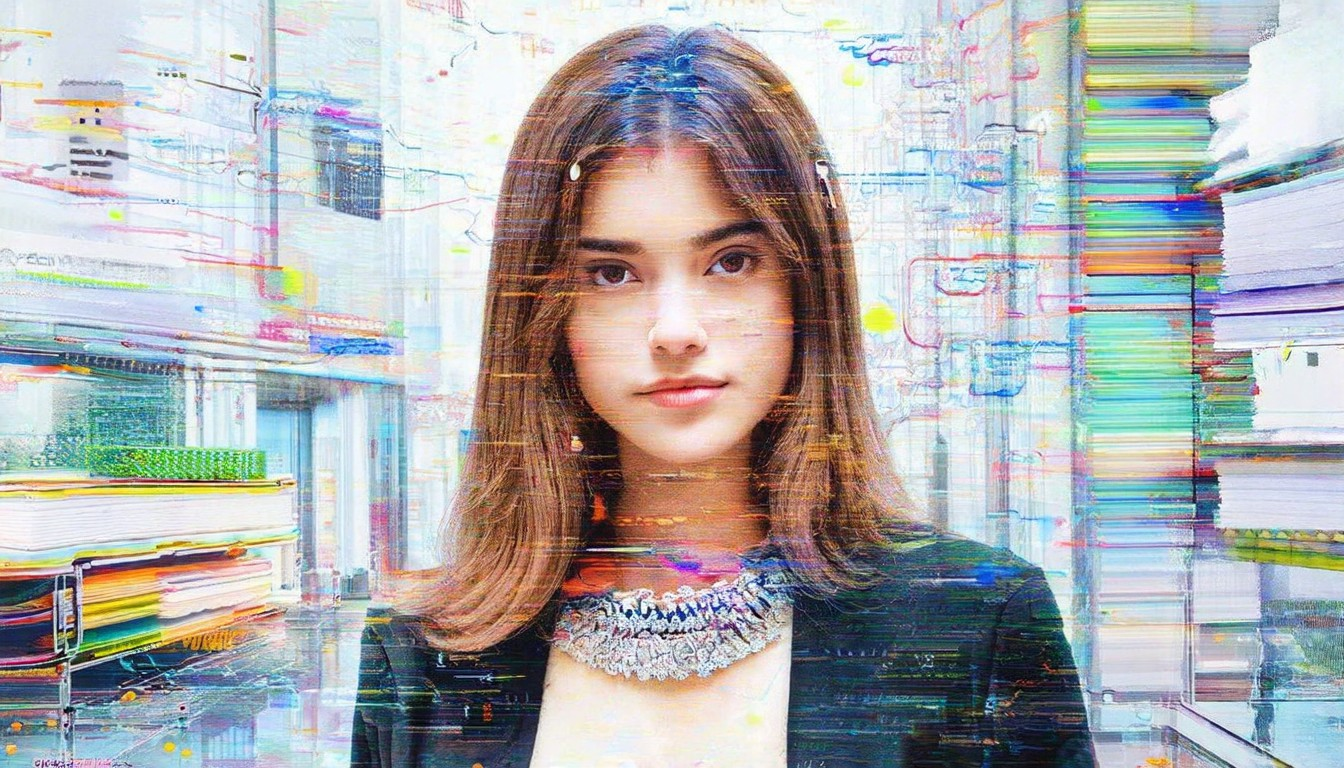

In [34]:
image

# HTML

In [ ]:
# Build web application using Flask
formatted_content = refined_blog_post.replace("\n", "<br>")

html_template = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>{selected_topic}</title>
    <style>
        h1 {{ color: #333; }}
        img {{ width: 80%; display: block; margin: 20px auto; }}
        p {{ line-height: 1.6; }}
    </style>
</head>
<body>
    <h1>{selected_topic}</h1>
    <img src="{image_url}" alt="{selected_topic}">
    <p>{formatted_content}</p>
</body>
</html>
"""



# Save the HTML file
with open("ai_blog.html", "w", encoding="utf-8") as f:
    f.write(html_template)

print("HTML page created: ai_blog.html")


HTML page created: ai_blog.html


In [84]:
from flask import Flask, render_template_string

app = Flask(__name__)

@app.route("/")
def home():
    return render_template_string(html_template)

if __name__ == "__main__":
    app.run(debug=True, port=5000)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


# Agents

In [ ]:

# Define a function for each step

def step_fetch_topics(state):
    """Fetches trending AI topics from an external source """
    state["topics"] = fetch_topics(keyword="AI NLP", num_articles=10)
    return state



def step_select_topic(state):
    choice = select_topic(state["topics"])
    state["selected_topic"] = choice
    return state


def step_generate_content(state):
    message = structure_messge(main_prompt,state["selected_topic"])

    state["blog_post"] = generate_content(message)
    return state

def step_refine_content(state):
    state["refined_blog_post"] = refine_content(state["selected_topic"],state["blog_post"],refine_prompt)
    return state

def step_generate_image(state):
    state["image_url"] = generate_image(state["selected_topic"])
    return state


def step_create_html(state):
    html_template = """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>{selected_topic}</title>
        <style>

        </style>
    </head>
    <body>
        <h1>{selected_topic}</h1>
        <img src="{image_url}" alt="{selected_topic}">
        <p>{refined_blog_post}</p>
    </body>
    </html>
    """

    html_output = html_template.format(
        selected_topic=state["selected_topic"],
        image_url=state["image_url"],
        refined_blog_post=state["refined_blog_post"].replace("\n", "<br>")
    )



    # Store the generated HTML inside the state dictionary
    state["html_page"] = html_output
    return state




In [ ]:

# State Schema
class ContentCreationState(TypedDict):
    topics: list
    selected_topic: str
    blog_post: str
    refined_blog_post: str
    image_url: str
    html_page: str

# Graph Scheman
graph = StateGraph(ContentCreationState)

# Workflow Steps
graph.add_node("fetch_topics", step_fetch_topics)
graph.add_node("select_topic", step_select_topic)
graph.add_node("generate_content", step_generate_content)
graph.add_node("refine_content", step_refine_content)
graph.add_node("generate_image", step_generate_image)
graph.add_node("create_html", step_create_html)  

# Execution Order
graph.add_edge("fetch_topics", "select_topic")
graph.add_edge("select_topic", "generate_content")
graph.add_edge("generate_content", "refine_content")
graph.add_edge("refine_content", "generate_image")
graph.add_edge("generate_image", "create_html") 

# Entry Point
graph.set_entry_point("fetch_topics")  

# Compile the Graph
workflow = graph.compile()

#Run the Workflow 
final_state = workflow.invoke({})  # Start the process

# Save the HTML file
with open("ai_blog.html", "w", encoding="utf-8") as f:
    f.write(final_state["html_page"])

# Step 8: Retrieve Final Output
print("\n Final HTML Output:\n", final_state["html_page"])



Select a topic:
1. Revolutionizing Support: AI-Powered Customer Service
2. How AI is Becoming More Human-Like With Emotional Intelligence
3. Healthcare Virtual Assistant Market to Reach $6248 Million by 2031, Driven by AI and NLP Innovations | Valuates Reports
4. Movate Technologies in Partnership with The Ma Foi Foundation launches Advanced Generative AI Lab at Mount Carmel College, Bangalore
5. Conversational GenAI: Building Advanced Virtual Assistants
6. Redefining Clinical Trials with Artificial Intelligence
7. Discovery Series – Harnessing AI: Natural Language Processing in Healthcare and Beyond
8. How AI language tools can help us understand human behavior
9. The impact of NLP on chatbot capabilities: The fintech perspective
10. The rise of AI-powered chatbots in digital apps
**********************************************
Enter the number of your chosen topic: 6
**********************************************


100%|██████████| 4/4 [02:18<00:00, 34.51s/it]



✅ Final HTML Output:
 
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Redefining Clinical Trials with Artificial Intelligence</title>
        <style>
            
        </style>
    </head>
    <body>
        <h1>Redefining Clinical Trials with Artificial Intelligence</h1>
        <img src="/content/generated_image.png" alt="Redefining Clinical Trials with Artificial Intelligence">
        <p>**Redefining Clinical Trials with Artificial Intelligence: Revolutionizing Healthcare**<br><br>Imagine a world where clinical trials are streamlined, patient outcomes are improved, and life-saving treatments are developed at an unprecedented pace. Welcome to the era of artificial intelligence (AI) in clinical trials, where the potential is vast and the impact could be transformative.<br><br>**The Current State of Clinical Trials: Inefficiencies and Costs**<br><br>Tra

In [ ]:
# Run the Falsk app

from flask import Flask, render_template_string

app = Flask(__name__)

@app.route("/")
def home():
    return render_template_string(html_template)

if __name__ == "__main__":
    app.run(debug=True, port=5000)
